In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import scanorama
import hvplot.pandas

#plt.rcParams["figure.figsize"] = (5, 5)

In [2]:
def rank_genes_groups_df(adata, group, pval_cutoff : float =None, logfc_cutoff=None): 
    d = pd.DataFrame() 
    for k in ['scores', 'names', 'logfoldchanges', 'pvals', 'pvals_adj']: 
        d[k] = adata.uns["rank_genes_groups"][k][group] 
    if pval_cutoff is not None: 
        d = d[d["pvals_adj"] < pval_cutoff] 
    if logfc_cutoff is not None: 
        d = d[d["logfoldchanges"].abs() > logfc_cutoff] 
    return d

In [3]:
s1 = sc.read_visium( "/user/ifrec/liuyuchen/Jupyter_notebooks/miyamoto_visum/sample1_visium/outs")
s2 = sc.read_visium( "/user/ifrec/liuyuchen/Jupyter_notebooks/miyamoto_visum/sample2_visium/outs")
s3 = sc.read_visium( "/user/ifrec/liuyuchen/Jupyter_notebooks/miyamoto_visum/sample3_visium/outs")
s4 = sc.read_visium( "/user/ifrec/liuyuchen/Jupyter_notebooks/miyamoto_visum/sample4_visium/outs")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:

s1.var_names_make_unique()
s2.var_names_make_unique()
s3.var_names_make_unique()
s4.var_names_make_unique()
sc.pp.calculate_qc_metrics(s1, inplace=True)
sc.pp.calculate_qc_metrics(s2, inplace=True)
sc.pp.calculate_qc_metrics(s3, inplace=True)
sc.pp.calculate_qc_metrics(s4, inplace=True)

/user/ifrec/liuyuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/user/ifrec/liuyuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/user/ifrec/liuyuchen/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

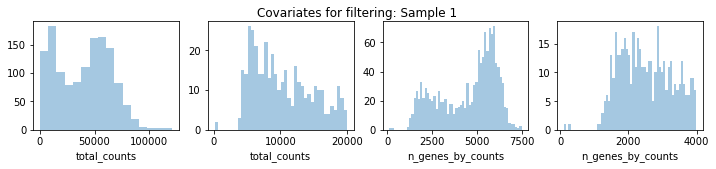

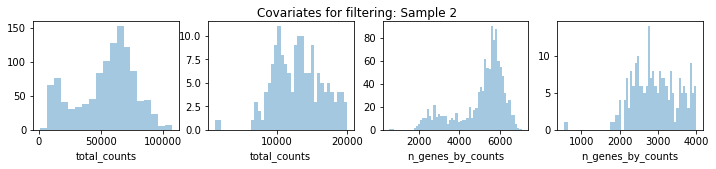

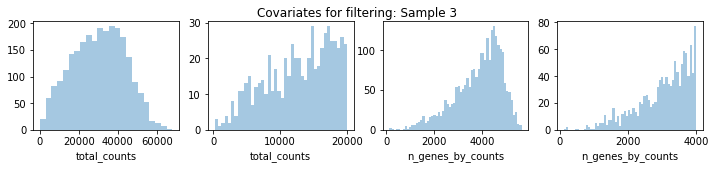

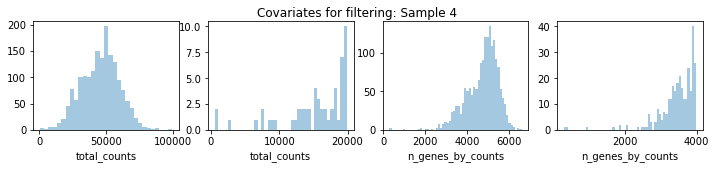

In [5]:
for name, adata in [
    ("Sample 1", s1),
    ("Sample 2", s2),
    ("Sample 3", s3),
    ("Sample 4", s4),
]:
    fig, axs = plt.subplots(1, 4, figsize=(12, 2))
    fig.suptitle(f"Covariates for filtering: {name}")

    sb.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
    sb.distplot(
        adata.obs["total_counts"][adata.obs["total_counts"] < 20000],
        kde=False,
        bins=40,
        ax=axs[1],
    )
    sb.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sb.distplot(
        adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
        kde=False,
        bins=60,
        ax=axs[3],
    )

In [6]:
for adata in [
    s1,
    s2,
    s3,
    s4,
]:
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000, inplace=True)

In [7]:
adatas = [s1, s2,s3,s4]
corrected = scanorama.correct_scanpy(adatas, return_dimred=True)


Found 31053 genes among all datasets
[[0.         0.67849057 0.10113208 0.06264151]
 [0.         0.         0.08348135 0.3357016 ]
 [0.         0.         0.         0.50442834]
 [0.         0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (2, 3)
Processing datasets (1, 3)
Processing datasets (0, 2)


In [8]:

adata_spatial = s1.concatenate(
    s2,s3,s4,
    uns_merge="unique",
    batch_key="library_id",batch_categories=[
        k
        for d in [
            s1.uns["spatial"],
            s2.uns["spatial"],
            s3.uns["spatial"],
            s4.uns["spatial"],
        ]
        for k, v in d.items()
    ],
)

In [9]:

corrected_X = corrected[0].concatenate(*corrected[1:], join='outer')
del corrected
adata_spatial.obsm["scanorama_embedding"] = corrected_X.obsm["X_scanorama"]
del corrected_X
sc.pp.neighbors(adata_spatial, use_rep="scanorama_embedding")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters")

... storing 'feature_types' as categorical
... storing 'genome' as categorical


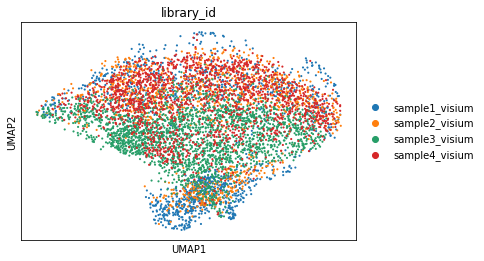

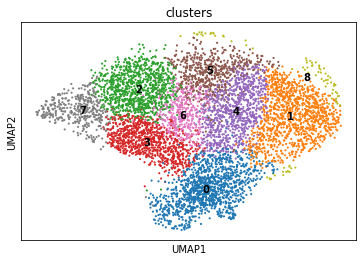

In [10]:
sc.pl.umap(
    adata_spatial, color="library_id", palette=sc.pl.palettes.default_20
)
sc.pl.umap(adata_spatial, color='clusters', legend_loc='on data',legend_fontsize=10 ) 

In [11]:
adata_spatial

AnnData object with n_obs × n_vars = 6654 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'library_id', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts-sample1_visium', 'mean_counts-sample1_visium', 'log1p_mean_counts-sample1_visium', 'pct_dropout_by_counts-sample1_visium', 'total_counts-sample1_visium', 'log1p_total_counts-sample1_visium', 'highly_variable-sample1_visium', 'means-sample1_visium', 'dispersions-sample1_visium', 'dispersions_norm-sample1_visium', 'n_cells_by_counts-sample2_visium', 'mean_counts-sample2_visium', 'log1p_mean_counts-sample2_visium', 'pct_dropout_by_counts-sample2_visium', 'total_counts-sample2_visium', 'log1p_total_counts-sample2_visium', 'highly_variable-sample2_visium', 'means-sample2_visium', 'dispersions-sample

In [12]:
clusters_colors = dict(
    zip([str(i) for i in range(len(adata_spatial.uns["clusters_colors"]))], adata_spatial.uns["clusters_colors"])
)

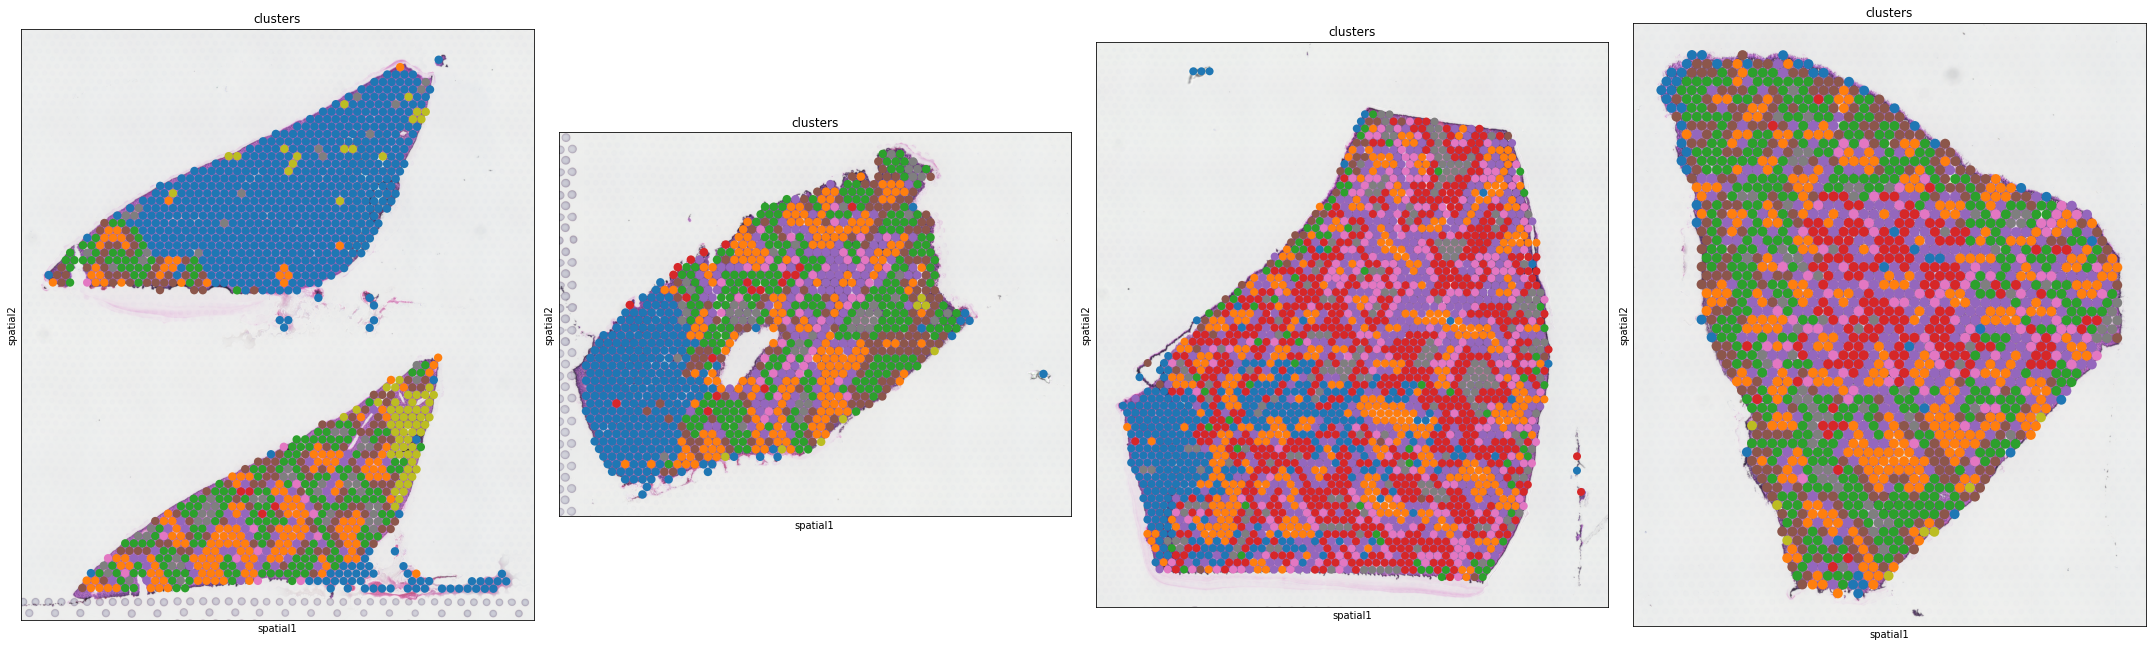

In [13]:

fig, axs = plt.subplots(1, 4, figsize=(30, 20))

for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        color=["clusters"],
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],

    )

plt.tight_layout()

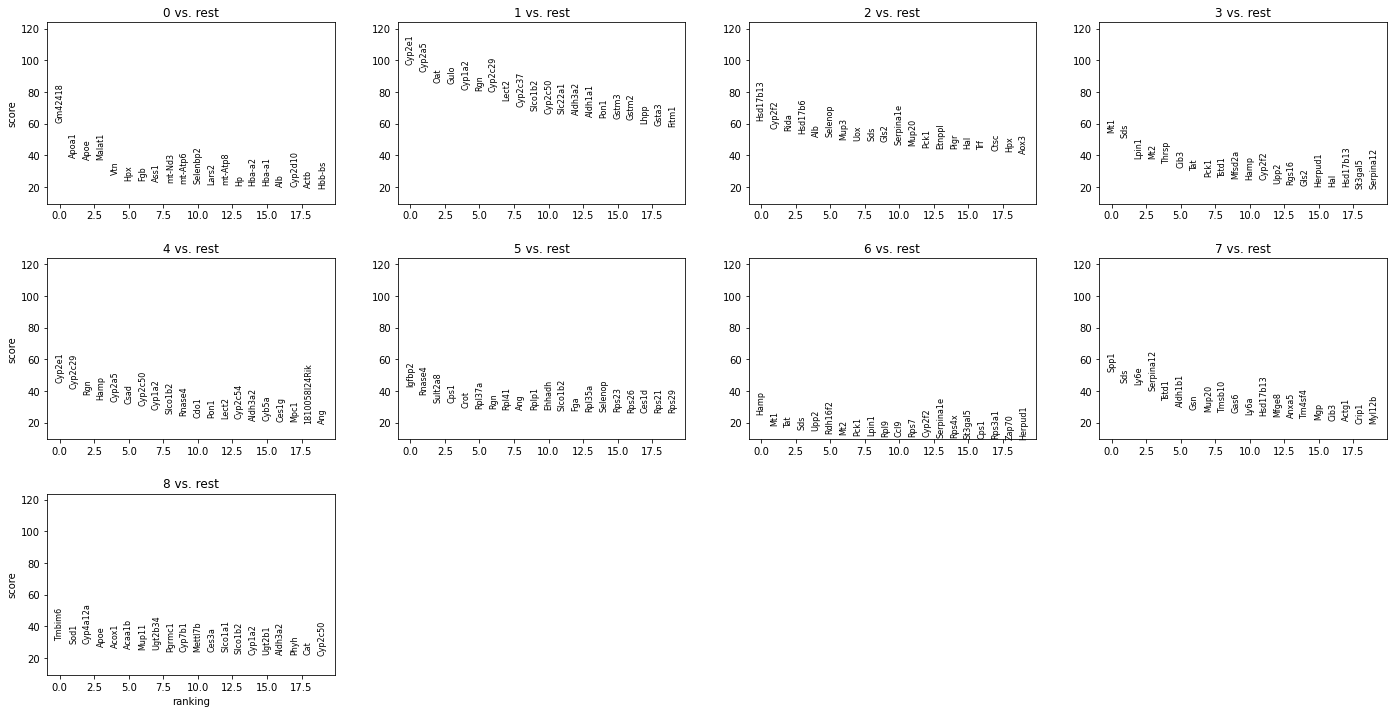

In [14]:
sc.tl.rank_genes_groups(adata_spatial, "clusters",use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(adata_spatial, key='rank_genes_groups')

In [ ]:
for i in range(11):
    sc.queries.enrich(adata_spatial, str(i),org = 'mmusculus', pval_cutoff=0.005, log2fc_min=1).to_csv('./cluster_'+str(i)+'_enrich.csv')

In [ ]:

sc.pl.rank_genes_groups_heatmap(adata_spatial, n_genes=3)

In [ ]:

rank_genes = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['names'])
rank_pavlues = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv('./DE_genes_clusters.csv')
top = list(set(sum(rank_genes.head(2).values.tolist(),[])))

In [ ]:
sc.tl.rank_genes_groups(adata_spatial, "library_id",use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(adata_spatial, key='rank_genes_groups')
rank_genes = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['names'])
sc.pl.rank_genes_groups_heatmap(adata_spatial, n_genes=3)
for cluster in rank_genes.columns:
    de_df = rank_genes_groups_df(adata_spatial, cluster).dropna()
    de_df['Negative_logP']=0-np.log10(de_df['pvals_adj'])
    plot = de_df.hvplot.scatter(
            "logfoldchanges", "Negative_logP", 
            hover_cols=["names"]
        )
    hvplot.save(plot, './volcano_cluster_'+cluster+'.html')
        


rank_genes = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['names'])
rank_pavlues = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv('./DE_genes_samples.csv') 

In [ ]:
de_df 

In [ ]:

for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        size=1.5,
        color=top,
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:


for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        size=1.5,
        color=['Cyp2e1','Cyp2f2'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:


for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        size=1.5,
        color=['Clec4f','Adgre1'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()


In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats     import norm
def Thrshold_by_Gaussian_with_plot(adata, tag):
    data = adata[:, tag].X.A
    N = len(data)
    data =  np.interp(data, (data.min(), data.max()), (0, 10))
   
    x = np.linspace(0, 10, N+1)
    gmm = GaussianMixture(n_components=2, covariance_type='spherical')
    gmm.fit(data)
    mu1 = gmm.means_[0, 0]
    mu2 = gmm.means_[1, 0]

    var1, var2 = gmm.covariances_
    wgt1, wgt2 = gmm.weights_
    cut_off = (mu2 + mu1)/2
    delta  = abs(mu2 - mu1)
    var = (var1+var2)/2
    #data[data == 0] = np.nan
    
    plt.hist(data, bins='auto', density=True)
    plt.vlines((mu1, mu2), ymin=0, ymax=0.5, color = 'y',label='Fitted Mean ')
    plt.vlines(cut_off, ymin=0, ymax=1, color = 'r', label='Threshold ')
    if mu1 >  0.1:
        plt.plot(x, norm.pdf(x, mu1, np.sqrt(var1)))
    if mu2 >  0.1:
        plt.plot(x, norm.pdf(x, mu2, np.sqrt(var1)))
    plt.legend()
    plt.title(tag + ' Gaussian Mixture Model')
    plt.show()
    return [delta, var, cut_off]

In [ ]:
def Binarize_Anti(adata,antilist):
    #Binarize the SP_genes and plot the distribution, count the cells
    anti_list = [x for x in set(antilist).intersection(set(adata.var_names))]
    for a in anti_list:
        thres = Thrshold_by_Gaussian_with_plot(adata, a)
        data = adata[:, a].X.A
        N = len(data)
        data =  np.interp(data, (data.min(), data.max()), (0, 10))
        tag=a.split('_')[0]
        adata.obs[a] = data
        adata.obs[tag+'_bin'] = np.where(data > thres[2], +1, 0)
        
        print(str(adata.obs[tag+'_bin'].sum())+' cells')
    return adata

In [ ]:
adata_spatial= Binarize_Anti(adata_spatial,['Cyp2f2','Cyp2e1','Clec4f','Adgre1'])


In [ ]:
adata_spatial.obs['ATP_LOW']=adata_spatial.obs['Cyp2e1_bin']-adata_spatial.obs['Cyp2f2_bin']
adata_spatial.obs['ATP_HI']=adata_spatial.obs['Cyp2f2_bin']-adata_spatial.obs['Cyp2e1_bin']

In [ ]:

for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        size=1.5,
        color=['ATP_HI','ATP_LOW'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:

for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        size=1.5,
        img_key="hires",
        color=['Clec4f_bin','Adgre1_bin'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:
adata_spatial.obs['library_id'].value_counts()

In [ ]:
adata

In [ ]:
adata_spatial.obs['ATP']='Mid'

In [ ]:
adata_spatial.obs.loc[adata_spatial.obs['ATP_HI']==1,'ATP'] = 'HI'
adata_spatial.obs.loc[adata_spatial.obs['ATP_LOW']==1,'ATP'] = 'LOW'

In [ ]:
sc.tl.rank_genes_groups(adata_spatial, "ATP",use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(adata_spatial, key='rank_genes_groups')

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata_spatial)

In [ ]:

rank_genes = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['names'])
for cluster in rank_genes.columns:
    de_df = rank_genes_groups_df(adata_spatial, cluster).dropna()
    de_df['Negative_logP']=0-np.log10(de_df['pvals_adj'])
    plot = de_df.hvplot.scatter(
            "logfoldchanges", "Negative_logP", 
            hover_cols=["names"]
        )
    hvplot.save(plot, './volcano_cluster_'+cluster+'.html')
        

rank_pavlues = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv('./DE_genes_ATP.csv')

In [ ]:
for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        size=1.5,
        img_key="hires",
        color='ATP',

    )

plt.tight_layout()

In [ ]:
GSE129516=sc.read_h5ad("./GSE129516.h5")

In [ ]:
adata = adata_spatial.copy()

In [ ]:

var_names = GSE129516.var_names.intersection(adata.var_names)
GSE129516 = GSE129516[:, var_names]
adata = adata[:, var_names]

In [ ]:
sc.pl.umap(GSE129516, color='leiden', legend_loc='on data',)

In [ ]:
GSE129516

In [ ]:
macros = GSE129516[GSE129516.obs['leiden'].isin(['2','8','5','20','21','11','19','18'])]

In [ ]:
sc.pl.umap(macros, color='leiden', legend_loc='on data',)

In [ ]:
sc.tl.leiden(macros)

sc.tl.umap(macros,  maxiter=100, min_dist=0.1, spread= 4.0)
    
sc.pl.umap(macros, color='leiden', legend_loc='on data',legend_fontsize=10) 
  

In [ ]:
sc.tl.rank_genes_groups(macros, "leiden",use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(macros, key='rank_genes_groups')
rank_genes = pd.DataFrame(macros.uns['rank_genes_groups']['names'])
top_2 = list(set(sum(rank_genes.head(2).values.tolist(),[])))
sc.pl.umap(macros,color=top_2,color_map= 'OrRd')

In [ ]:
adata_spatial.write('./miyamoto_liver.h5')

In [ ]:
GSE129516.uns['neighbors']['params']['metric'] ='euclidean'

In [ ]:
sc.pp.pca(adata)

In [ ]:
sc.tl.ingest( adata,GSE129516,  obs='leiden')

In [ ]:
adata_sc = adata.concatenate(GSE129516, batch_categories=[ 'visium','scRNASeq'])

In [ ]:
adata_sc.obs.clusters = adata_sc.obs.clusters.astype('category')
adata_sc.obs.clusters.cat.reorder_categories(adata.obs.clusters.cat.categories, inplace=True)  # fix category ordering


In [ ]:
sc.pl.umap(adata_sc, color='batch')
sc.pl.umap(adata_sc, color='clusters')

In [ ]:
sc.pl.umap(adata_sc, color='leiden')

In [ ]:
sc.pl.umap(adata, color=['clusters','leiden'])

In [ ]:
adata.obs.groupby(['clusters'])['leiden'].value_counts(normalize = True).unstack().plot.bar(stacked=True)
ax = plt.subplot(111)
plt.ylabel('Composition of cell clusters')
plt.xlabel('Region cluster')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      
        
        

In [ ]:
sc.queries.enrich(adata_spatial, "HI",org = 'mmusculus', pval_cutoff=0.005, log2fc_min=1).to_csv('./ATP_HI_enrich.csv')
sc.queries.enrich(adata_spatial,"LOW", org = 'mmusculus', pval_cutoff=0.005, log2fc_min=1).to_csv('./ATP_LOW_enrich.csv')

In [ ]:
adata.obs['Macros']=0
adata.obs.loc[(adata.obs['leiden'] == '2'),'Macros'] = 1

In [ ]:
adata.obs['leiden'].value_counts()

In [ ]:
adata.obs['Macros'].value_counts()

In [ ]:
adata.obs['ATP_Hi_Macros']=0
adata.obs.loc[(adata.obs['Macros'] == 1)&(adata.obs['ATP'] == "HI"),'ATP_Hi_Macros'] = 1

In [ ]:
adata.obs['ATP_LOW_Macros']=0
adata.obs.loc[(adata.obs['Macros'] == 1)&(adata.obs['ATP'] == "LOW"),'ATP_LOW_Macros'] = 1

In [ ]:
adata.obs['ATP_Hi_Macros'].value_counts()

In [ ]:
adata.obs['ATP_LOW_Macros'].value_counts()

In [ ]:
for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        size=1.5,
        img_key="hires",
        color=['Macros','ATP_Hi_Macros','ATP_LOW_Macros'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:
adata.obs['Clec4f_minus_Macros']=0
adata.obs.loc[(adata.obs['leiden'] == '8')|(adata.obs['leiden'] == '5'),'Clec4f_minus_Macros'] = 1

In [ ]:
adata.obs['Clec4f_minus_Macros'].value_counts()

In [ ]:
adata.obs['ATP_Hi_Clec4f_minus']=0
adata.obs.loc[(adata.obs['Clec4f_minus_Macros'] == 1)&(adata.obs['ATP'] == "HI"),'ATP_Hi_Clec4f_minus'] = 1

In [ ]:
adata.obs['ATP_Hi_Clec4f_minus'].value_counts()

In [ ]:
adata.obs['ATP_LOW_Clec4f_minus']=0
adata.obs.loc[(adata.obs['Clec4f_minus_Macros'] == 1)&(adata.obs['ATP'] == "LOW"),'ATP_LOW_Clec4f_minus'] = 1

In [ ]:
adata.obs['ATP_LOW_Clec4f_minus'].value_counts()

In [ ]:
for i, library in enumerate(
   ['sample1_visium', 'sample2_visium', 'sample3_visium', 'sample4_visium']
):
    ad = adata[adata.obs.library_id == library, :].copy()
    ad.uns["spatial"]= adatas[i].uns["spatial"]
    sc.pl.spatial(
        ad,
        img_key="hires",
        size=1.5,
        color=['Clec4f_minus_Macros','ATP_Hi_Clec4f_minus','ATP_LOW_Clec4f_minus'],
        color_map= 'OrRd',
        
    )

plt.tight_layout()

In [ ]:
adata.obs['Macrophage'] ='non'
adata.obs.loc[adata.obs['Macros'] == 1,'Macrophage'] = 'MID'
adata.obs.loc[adata.obs['Clec4f_minus_Macros'] == 1,'Macrophage'] = 'Clec4f_minus_MID'
adata.obs.loc[adata.obs['ATP_Hi_Macros']==1,'Macrophage'] = 'ATP_Hi'
adata.obs.loc[adata.obs['ATP_LOW_Macros']==1,'Macrophage'] = 'ATP_LOW'
adata.obs.loc[adata.obs['ATP_LOW_Clec4f_minus']==1,'Macrophage'] = 'ATP_LOW_Clec4f_minus'
adata.obs.loc[adata.obs['ATP_Hi_Clec4f_minus']==1,'Macrophage'] = 'ATP_Hi_Clec4f_minus'


In [ ]:
adata.obs['Macrophage'].value_counts()

In [ ]:
sc.tl.rank_genes_groups(adata, 'Macrophage',use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(adata, key='rank_genes_groups')

In [ ]:
rank_pavlues = pd.DataFrame(adata.uns['rank_genes_groups']["pvals_adj"])
rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
for cluster in rank_genes.columns:
    de_df = rank_genes_groups_df(adata_spatial, cluster).dropna()
    de_df['Negative_logP']=0-np.log10(de_df['pvals_adj'])
    plot = de_df.hvplot.scatter(
            "logfoldchanges", "Negative_logP", 
            hover_cols=["names"]
        )
    hvplot.save(plot, './volcano_cluster_'+cluster+'.html')
        

rank_genes = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['names'])
rank_pavlues = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['pvals'])
rank_pavlues.rename(columns=lambda x: x+'_pvals', inplace=True)
rank_fold = pd.DataFrame(adata_spatial.uns['rank_genes_groups']['logfoldchanges'])
rank_fold.rename(columns=lambda x: x+'_logfoldchanges', inplace=True)
pd.concat([rank_genes, rank_pavlues,rank_fold], axis=1, join='inner').to_csv('./DE_genes_in_Macros.csv')

In [ ]:
adata.uns['rank_genes_groups']

In [ ]:
sc.tl.dendrogram(adata,groupby='Macrophage' )

In [ ]:
sc.pl.rank_genes_groups_heatmap(adata,n_genes=5)

In [ ]:
macro_types = [x for x in adata.obs['Macrophage'].value_counts().index]

In [ ]:
macro_types.remove('ATP_Hi_Clec4f_minus')

In [ ]:
macros=adata[adata.obs['Macrophage']!= 'non']

In [ ]:
sc.tl.rank_genes_groups(macros, 'Macrophage',use_raw=False, n_genes=adata.var_names.size)
sc.pl.rank_genes_groups(macros, key='rank_genes_groups')

In [ ]:
sc.tl.dendrogram(macros,groupby='Macrophage' )

In [ ]:
sc.pl.rank_genes_groups_heatmap(macros,n_genes=5)